In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  Face Mask Detection Pipeline

**Author:** Your Name  
**Date:** 2025-08-XX  

This notebook implements a face-mask detection system:

1. **Data Loading & Preprocessing**  
2. **Model Definitions**  
   - Custom CNN  
   - Transfer-Learning: VGG16, MobileNetV2, ResNet50, DenseNet121  
3. **Training & Evaluation**  
4. **Results & Analysis**  

---

> **How to use:**  
> 1. Mount or download your “Face Mask Dataset” with `Train/Validation/Test` subfolders.  
> 2. Adjust `base_path` in Cell 1.  
> 3. Run cells in order, or re-run individual model-training cells as needed.  


In [6]:
import tensorflow as tf
import numpy as np
import random
import os
import json
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, callbacks, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, DenseNet121
import time

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Define paths - UPDATE THESE TO MATCH YOUR DIRECTORY STRUCTURE
train_path = "/kaggle/input/face-mask-detection/Face Mask Dataset/Train"
test_path = "/kaggle/input/face-mask-detection/Face Mask Dataset/Test"
val_path = "/kaggle/input/face-mask-detection/Face Mask Dataset/Validation"

print("Checking directory structure:")
print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Test path exists: {os.path.exists(test_path)}")
print(f"Validation path exists: {os.path.exists(val_path)}")

# Check categories in each directory
for path_name, path in [("Train", train_path), ("Test", test_path), ("Validation", val_path)]:
    if os.path.exists(path):
        categories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        print(f"{path_name} categories: {categories}")

# Initialize the system with separate paths
system = FaceDetectionSystem(train_path, test_path, val_path)

# Load data from separate directories (this replaces the train_test_split approach)
print("\n" + "="*60)
print("LOADING DATA FROM SEPARATE DIRECTORIES")
print("="*60)

X_sets, y_sets = system.load_and_preprocess_data()
(X_train, X_val, X_test), (y_train_cat, y_val_cat, y_test_cat), (y_train_orig, y_val_orig, y_test_orig) = system.prepare_data(X_sets, y_sets)

print("\nData loading and preparation complete!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Display class distribution
print(f"\nClass Distribution:")
print(f"Training: WithMask={np.sum(y_train_orig == 0)}, WithoutMask={np.sum(y_train_orig == 1)}")
print(f"Validation: WithMask={np.sum(y_val_orig == 0)}, WithoutMask={np.sum(y_val_orig == 1)}")
print(f"Test: WithMask={np.sum(y_test_orig == 0)}, WithoutMask={np.sum(y_test_orig == 1)}")

Checking directory structure:
Train path exists: True
Test path exists: True
Validation path exists: True
Train categories: ['WithoutMask', 'WithMask']
Test categories: ['WithoutMask', 'WithMask']
Validation categories: ['WithoutMask', 'WithMask']

LOADING DATA FROM SEPARATE DIRECTORIES
Loading and preprocessing data from separate directories...
Loading training data from: /kaggle/input/face-mask-detection/Face Mask Dataset/Train
  WithMask: 5057 images loaded
  WithoutMask: 5005 images loaded
Total training images loaded: 10062
Loading test data from: /kaggle/input/face-mask-detection/Face Mask Dataset/Test
  WithMask: 490 images loaded
  WithoutMask: 509 images loaded
Total test images loaded: 999
Loading validation data from: /kaggle/input/face-mask-detection/Face Mask Dataset/Validation
  WithMask: 405 images loaded
  WithoutMask: 400 images loaded
Total validation images loaded: 805

Dataset Summary:
Training set: (10062, 224, 224, 3), Labels: [5057 5005]
Validation set: (805, 224

### 📂 Load & Preprocess “Train” Split

This cell will:
- Read images from `base_path/Train/{WithMask,WithoutMask}`  
- Detect faces via Haar cascade and crop them  
- Resize to `(224,224)` and normalize pixel values  
- Return `X_train, y_train` arrays ready for training  



TRAINING CUSTOM CNN MODEL


I0000 00:00:1754579903.329699      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15257 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Custom CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,435,682 (5.48 MB)

 Trainable params: 1,435,682 (5.48 MB)

 Non-trainable params: 0 (0.00 B)


Training Custom_CNN...
Epoch 1/25


I0000 00:00:1754579915.506548     110 service.cc:148] XLA service 0x7ff41c109b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754579915.507425     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754579916.093498     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/314 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.5234 - loss: 0.6842   

I0000 00:00:1754579927.944357     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.6146 - loss: 0.5946
Epoch 1: val_loss improved from inf to 0.19825, saving model to best_custom_cnn_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 124s 338ms/step - accuracy: 0.6151 - loss: 0.5941 - val_accuracy: 0.9130 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 2/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8750 - loss: 0.2972
Epoch 2: val_loss did not improve from 0.19825
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.2972 - val_accuracy: 0.9056 - val_loss: 0.2098 - learning_rate: 0.0010
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9134 - loss: 0.2318
Epoch 3: val_loss improved from 0.19825 to 0.16441, saving model to best_custom_cnn_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - accuracy: 0.9134 - loss: 0.2317 - val_accuracy: 0.9304 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 4/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9062 - loss: 0.3286


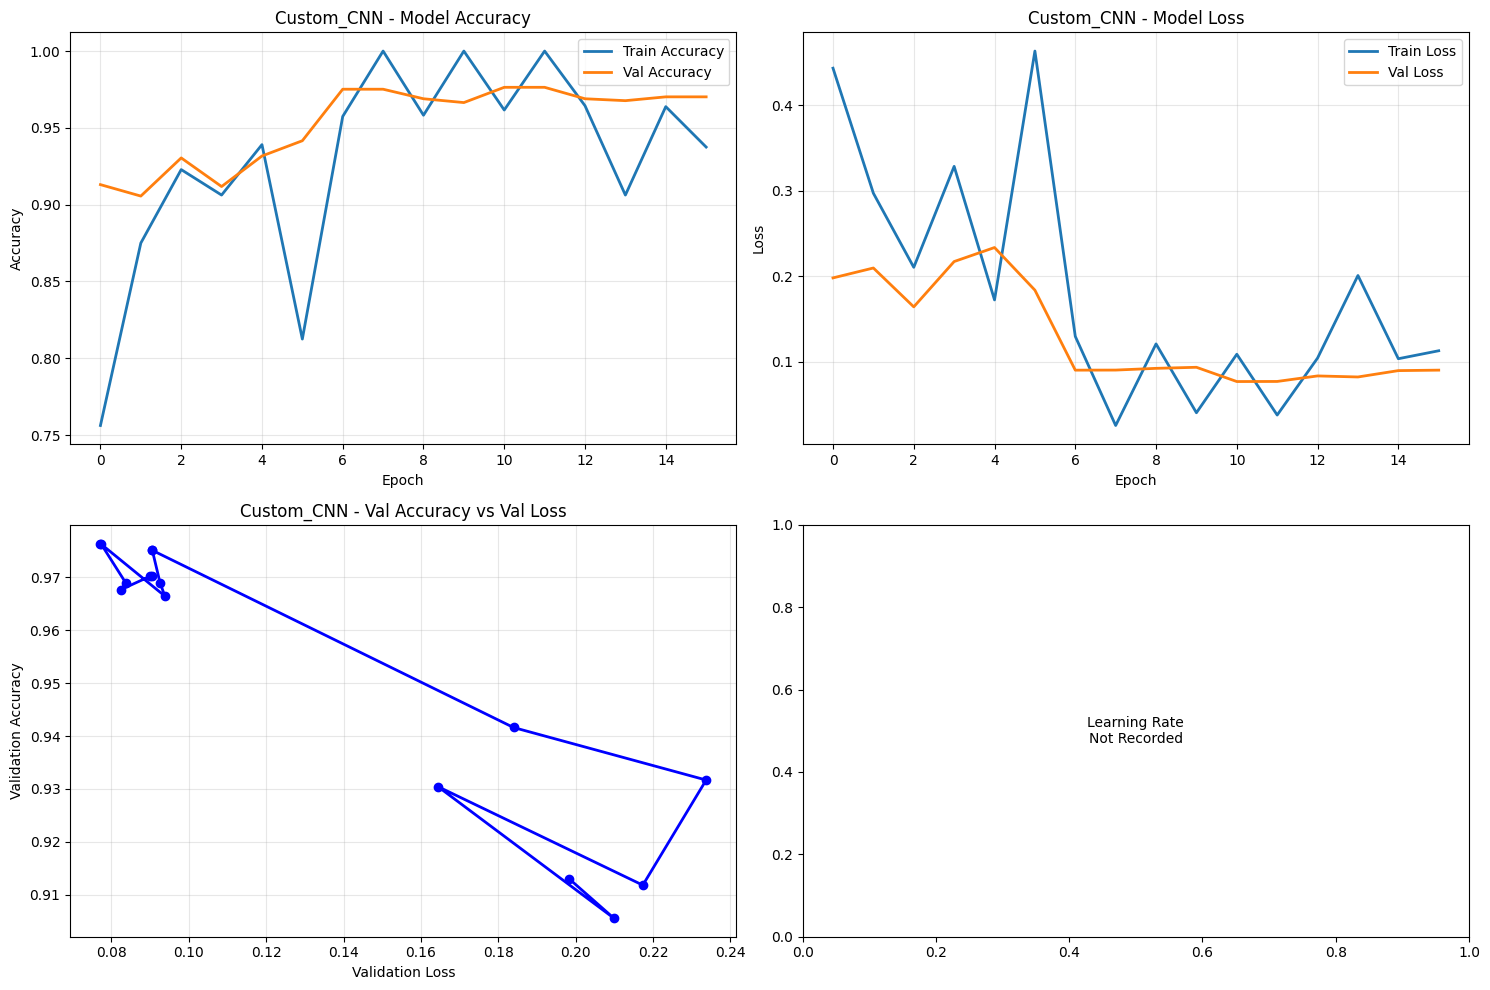


--- Analysis for Custom_CNN ---
Why validation loss might increase:
1. Overfitting: Model memorizes training data but fails on validation
2. Learning rate too high: Causes oscillations in loss
3. Insufficient regularization: Model complexity exceeds data complexity
4. Data imbalance: Model biased towards majority class
5. Batch size effects: Small batches can cause noisy gradients


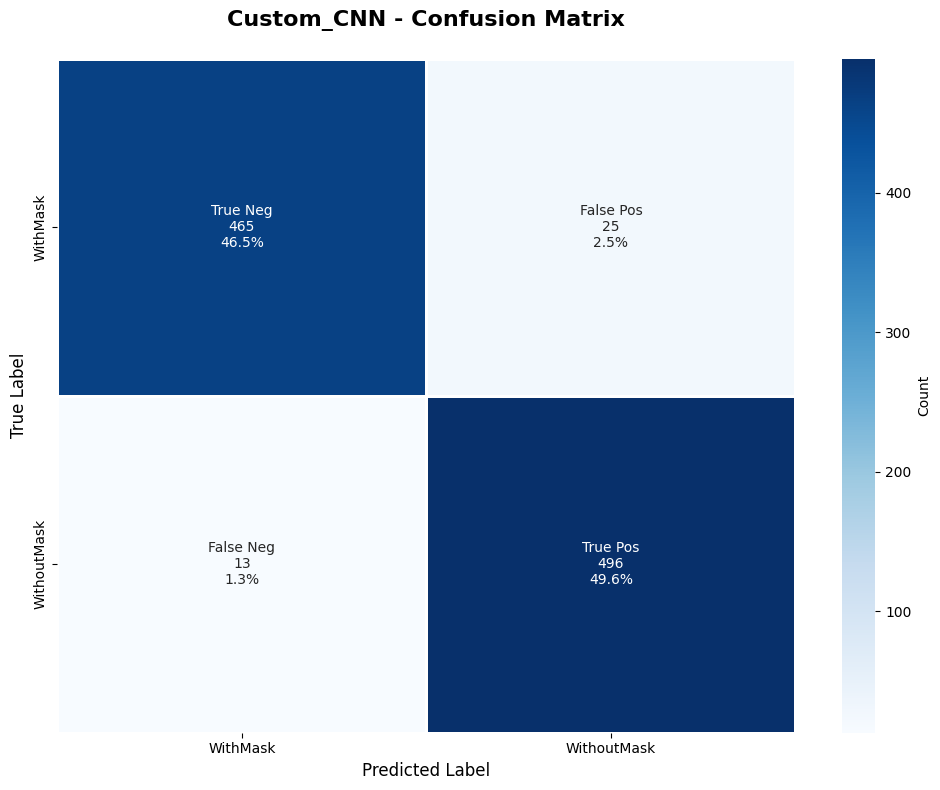


CUSTOM CNN RESULTS
Training Time: 802.84 seconds
Test Accuracy: 0.9620
Test Loss: 0.1098

Classification Report:
WithMask: Precision=0.973, Recall=0.949, F1=0.961
WithoutMask: Precision=0.952, Recall=0.974, F1=0.963
✅ Custom CNN training completed successfully!


In [5]:
# Train Custom CNN Model
print("="*50)
print("TRAINING CUSTOM CNN MODEL")
print("="*50)

try:
    # Create model
    custom_model = system.create_custom_model()
    print("Custom CNN Model Summary:")
    custom_model.summary()
    
    # Train model
    start_time = time.time()
    trained_custom_model, custom_history = system.train_model(
        custom_model, 'Custom_CNN', X_train, X_val, y_train_cat, y_val_cat
    )
    training_time = time.time() - start_time
    
    # Store results
    system.models['Custom_CNN'] = trained_custom_model
    system.histories['Custom_CNN'] = custom_history
    
    # Evaluate model
    custom_results = system.evaluate_model(
        trained_custom_model, 'Custom_CNN', X_test, y_test_cat, y_test_orig
    )
    system.results['Custom_CNN'] = custom_results
    
    # Plot results
    system.plot_training_history(custom_history, 'Custom_CNN')
    system.plot_improved_confusion_matrix(custom_results['confusion_matrix'], 'Custom_CNN')
    
    # Print results
    print(f"\n{'='*40}")
    print(f"CUSTOM CNN RESULTS")
    print(f"{'='*40}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Test Accuracy: {custom_results['test_accuracy']:.4f}")
    print(f"Test Loss: {custom_results['test_loss']:.4f}")
    print("\nClassification Report:")
    for class_name in system.categories:
        metrics = custom_results['classification_report'][class_name]
        print(f"{class_name}: Precision={metrics['precision']:.3f}, "
              f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
    
    print("✅ Custom CNN training completed successfully!")
    
except Exception as e:
    print(f"❌ Error in Custom CNN training: {e}")
    import traceback
    traceback.print_exc()

| Parameter         | Description                         | Default |
|-------------------|-------------------------------------|---------|
| `IMG_SIZE`        | Image resize dimensions             | (224,224) |
| `BATCH_SIZE`      | Number of images per training step  | 32      |
| `EPOCHS`          | Maximum training epochs             | 25      |
| `LEARNING_RATE`   | Initial learning rate for Adam      | 1e-4    |


TRAINING VGG16 MODEL
Attempting to download VGG16 weights (attempt 1/3)...
✅ VGG16 model created successfully!
VGG16 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training VGG16...
Epoch 1/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8304 - loss: 0.3570
Epoch 1: val_loss improved from inf to 0.10409, saving model to best_vgg16_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 111s 336ms/step - accuracy: 0.8307 - loss: 0.3566 - val_accuracy: 0.9590 - val_loss: 0.1041 - learning_rate: 0.0010
Epoch 2/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9688 - loss: 0.2801
Epoch 2: val_loss did not improve from 0.10409
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.2801 - val_accuracy: 0.9590 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9632 - loss: 0.1028
Epoch 3: val_loss improved from 0.10409 to 0.06742, saving model to best_vgg16_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - accuracy: 0.9632 - loss: 0.1028 - val_accuracy: 0.9826 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 4/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.

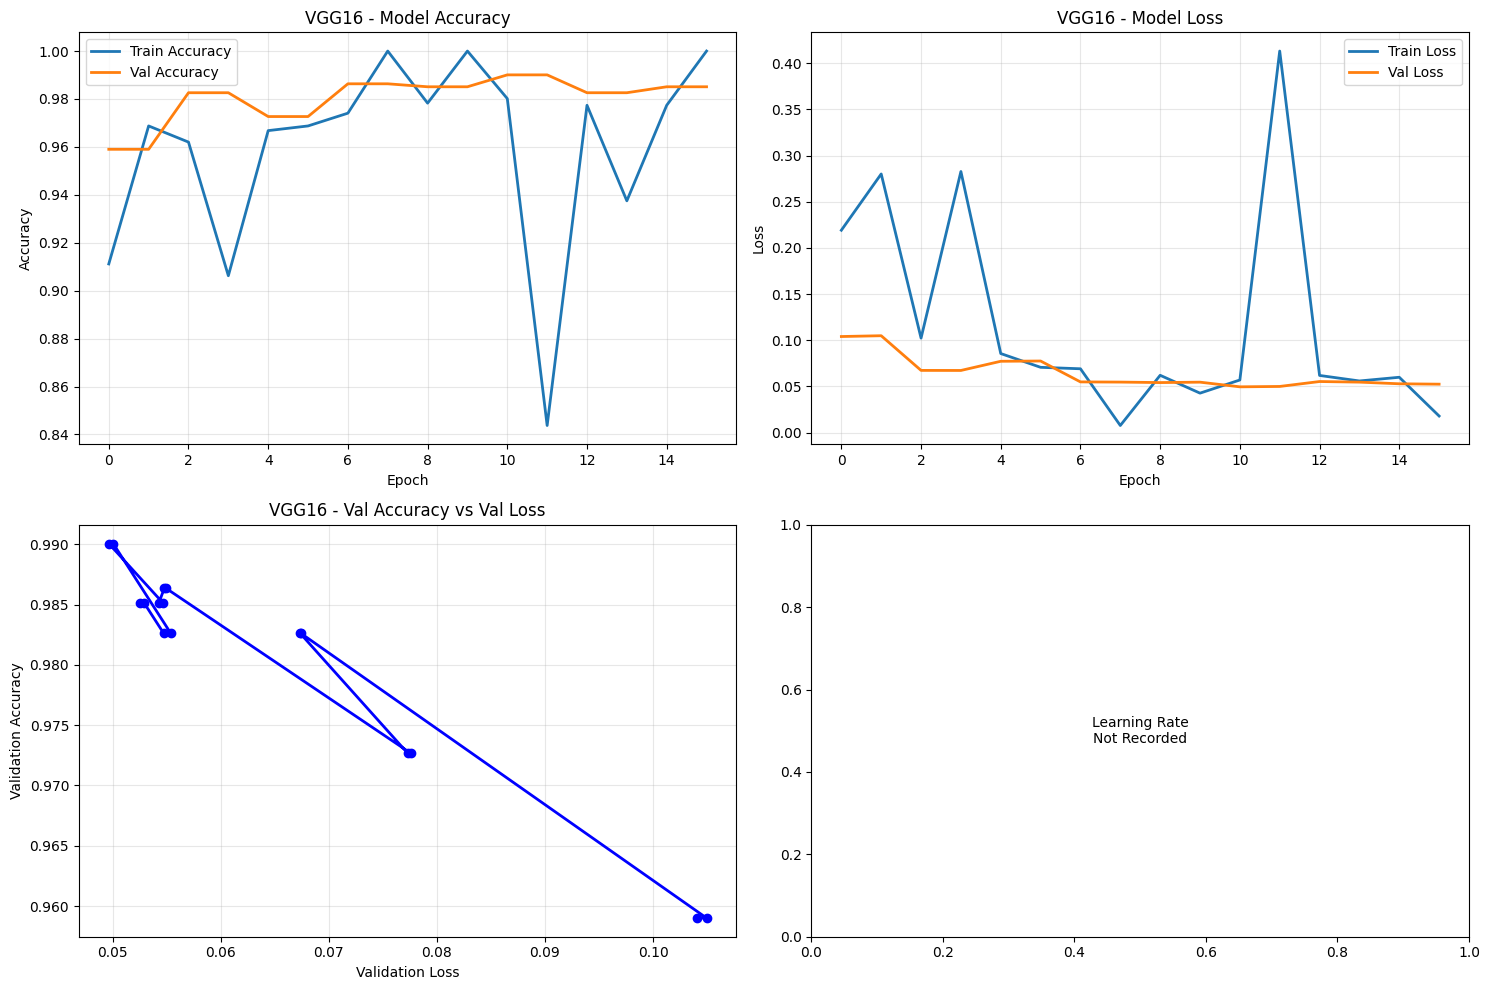


--- Analysis for VGG16 ---
Why validation loss might increase:
1. Overfitting: Model memorizes training data but fails on validation
2. Learning rate too high: Causes oscillations in loss
3. Insufficient regularization: Model complexity exceeds data complexity
4. Data imbalance: Model biased towards majority class
5. Batch size effects: Small batches can cause noisy gradients


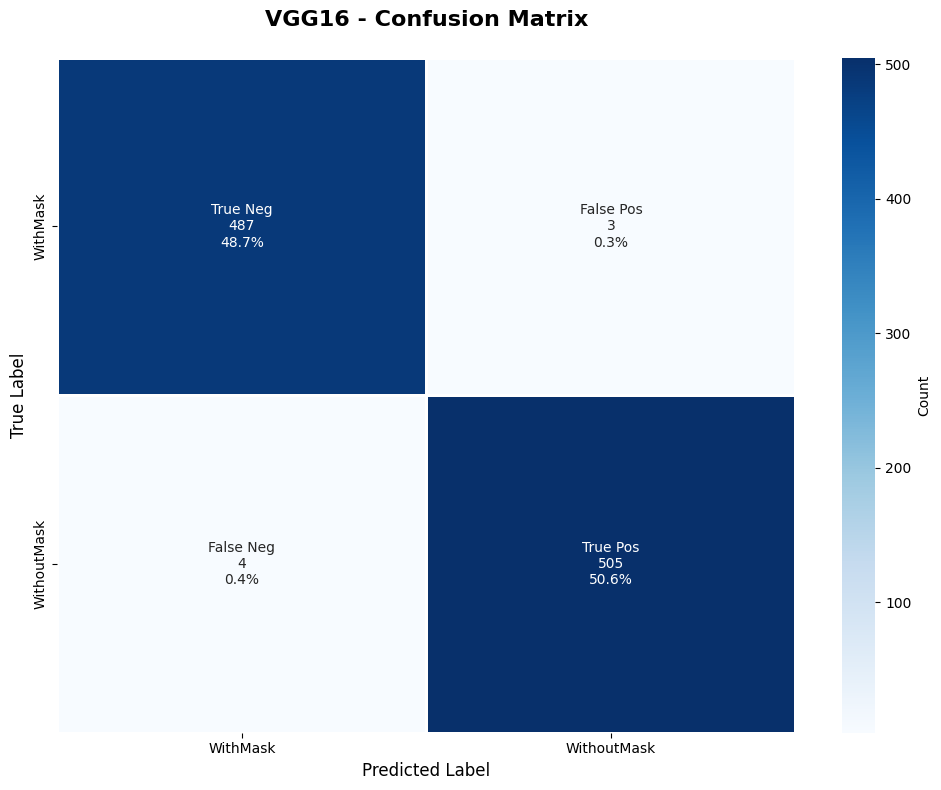


VGG16 RESULTS
Training Time: 801.66 seconds
Test Accuracy: 0.9930
Test Loss: 0.0319

Classification Report:
WithMask: Precision=0.992, Recall=0.994, F1=0.993
WithoutMask: Precision=0.994, Recall=0.992, F1=0.993
✅ VGG16 training completed successfully!


In [13]:
# Train VGG16 Model with robust error handling
print("="*50)
print("TRAINING VGG16 MODEL")
print("="*50)
try:
    # Try to create VGG16 model with retries
    max_retries = 3
    vgg16_model = None
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to download VGG16 weights (attempt {attempt + 1}/{max_retries})...")
            vgg16_model = system.create_transfer_learning_model('VGG16')
            print("✅ VGG16 model created successfully!")
            break
        except Exception as download_error:
            print(f"❌ Download attempt {attempt + 1} failed: {download_error}")
            if attempt < max_retries - 1:
                print("⏳ Retrying in 10 seconds...")
                time.sleep(10)
            else:
                print("🔄 Trying offline version without pre-trained weights...")
                try:
                    vgg16_model = system.create_transfer_learning_model_offline('VGG16')
                    print("✅ VGG16 model created without pre-trained weights!")
                except Exception as offline_error:
                    print(f"❌ Offline creation also failed: {offline_error}")
                    vgg16_model = None
    
    if vgg16_model is not None:
        print("VGG16 Model Summary:")
        vgg16_model.summary()
        
        # Train model
        start_time = time.time()
        trained_vgg16_model, vgg16_history = system.train_model(
            vgg16_model, 'VGG16', X_train, X_val, y_train_cat, y_val_cat
        )
        training_time = time.time() - start_time
        
        # Store results
        system.models['VGG16'] = trained_vgg16_model
        system.histories['VGG16'] = vgg16_history
        
        # Evaluate model
        vgg16_results = system.evaluate_model(
            trained_vgg16_model, 'VGG16', X_test, y_test_cat, y_test_orig
        )
        system.results['VGG16'] = vgg16_results
        
        # Plot results
        system.plot_training_history(vgg16_history, 'VGG16')
        system.plot_improved_confusion_matrix(vgg16_results['confusion_matrix'], 'VGG16')
        
        # Print results
        print(f"\n{'='*40}")
        print(f"VGG16 RESULTS")
        print(f"{'='*40}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Test Accuracy: {vgg16_results['test_accuracy']:.4f}")
        print(f"Test Loss: {vgg16_results['test_loss']:.4f}")
        print("\nClassification Report:")
        for class_name in system.categories:
            metrics = vgg16_results['classification_report'][class_name]
            print(f"{class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
        
        print("✅ VGG16 training completed successfully!")
    else:
        print("❌ VGG16 training skipped due to model creation issues.")
        
except Exception as e:
    print(f"❌ Error in VGG16 training: {e}")
    import traceback
    traceback.print_exc()

TRAINING MOBILENETV2 MODEL
Attempting to download MobileNetV2 weights (attempt 1/3)...
✅ MobileNetV2 model created successfully!
MobileNetV2 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Training MobileNetV2...
Epoch 1/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9360 - loss: 0.1712
Epoch 1: val_loss improved from inf to 0.02469, saving model to best_mobilenetv2_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 113s 324ms/step - accuracy: 0.9361 - loss: 0.1710 - val_accuracy: 0.9913 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 2/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 2: val_loss improved from 0.02469 to 0.02321, saving model to best_mobilenetv2_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9913 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9834 - loss: 0.0466
Epoch 3: val_loss improved from 0.02321 to 0.02108, saving model to best_mobilenetv2_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - accuracy: 0.9834 - loss: 0.0466 - val_accuracy: 0.9963 - val_loss: 0.0211 - learning_rate: 0.0010
Epoc

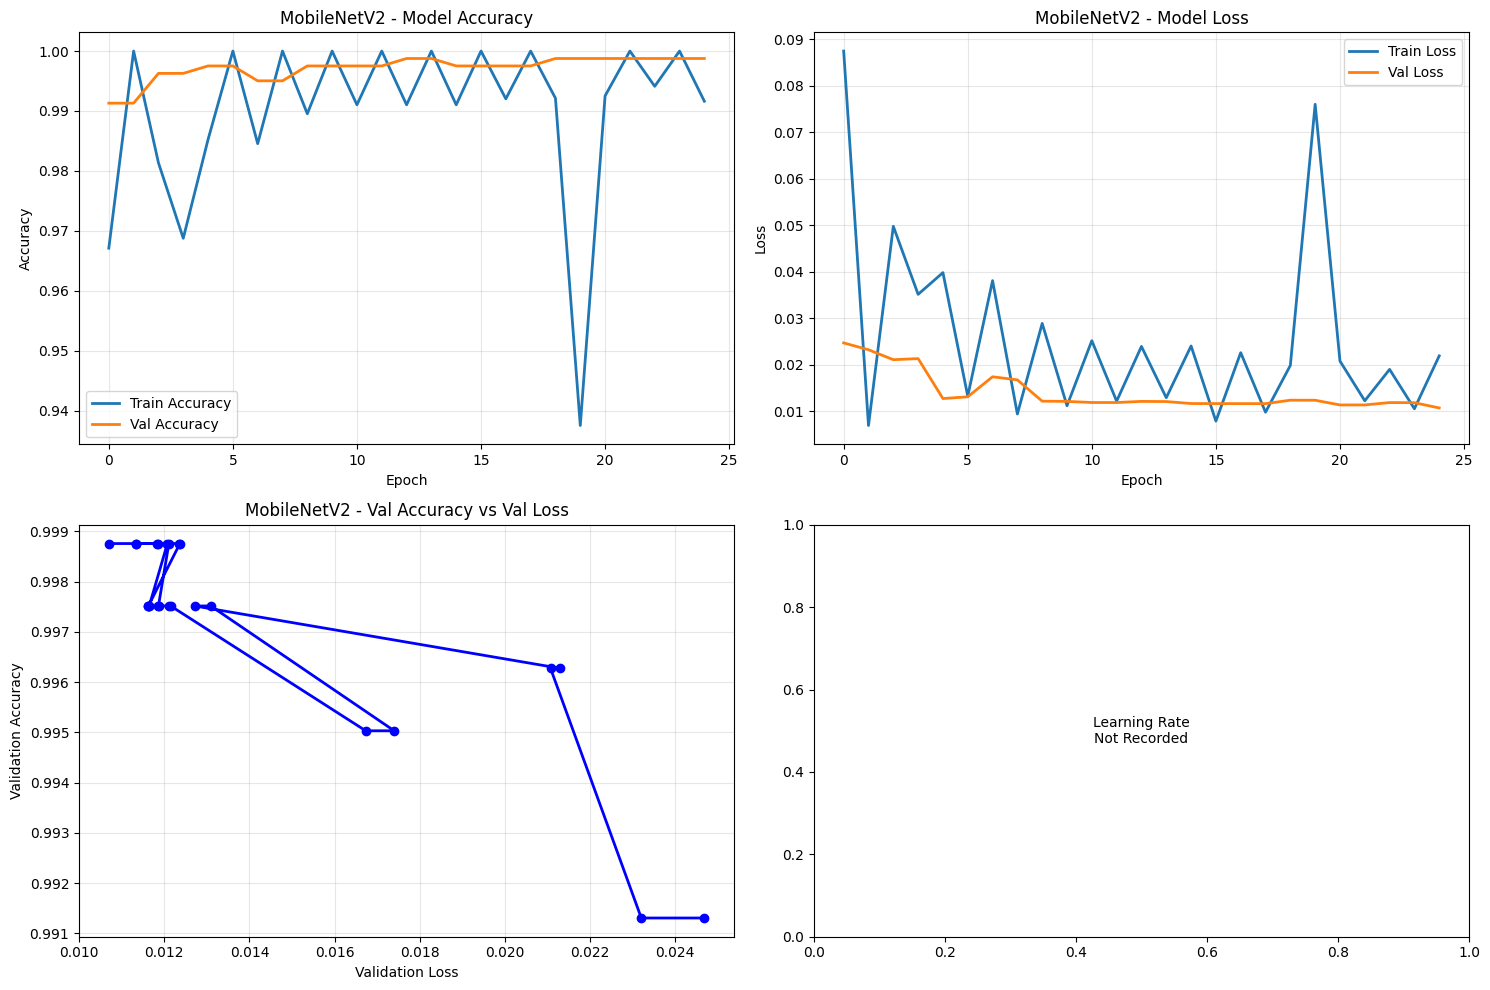


--- Analysis for MobileNetV2 ---
Why validation loss might increase:
1. Overfitting: Model memorizes training data but fails on validation
2. Learning rate too high: Causes oscillations in loss
3. Insufficient regularization: Model complexity exceeds data complexity
4. Data imbalance: Model biased towards majority class
5. Batch size effects: Small batches can cause noisy gradients


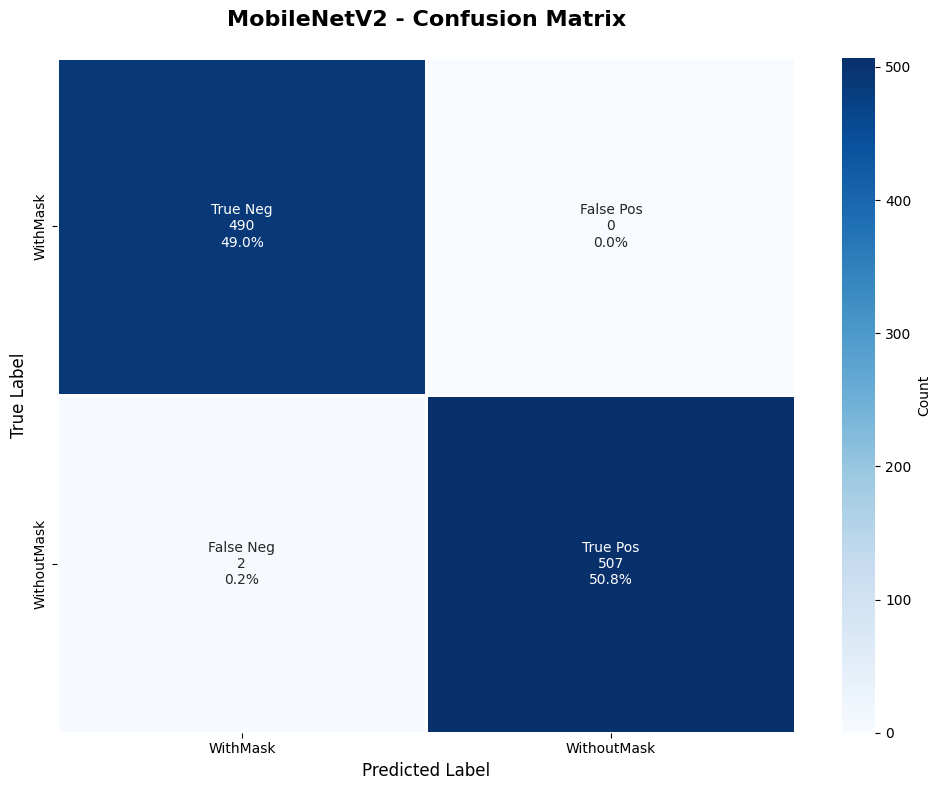


MOBILENETV2 RESULTS
Training Time: 1247.88 seconds
Test Accuracy: 0.9980
Test Loss: 0.0096

Classification Report:
WithMask: Precision=0.996, Recall=1.000, F1=0.998
WithoutMask: Precision=1.000, Recall=0.996, F1=0.998
✅ MobileNetV2 training completed successfully!


In [14]:
# Train MobileNetV2 Model
print("="*50)
print("TRAINING MOBILENETV2 MODEL")
print("="*50)

try:
    # Create model with retry logic
    max_retries = 3
    mobilenet_model = None
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to download MobileNetV2 weights (attempt {attempt + 1}/{max_retries})...")
            mobilenet_model = system.create_transfer_learning_model('MobileNetV2')
            print("✅ MobileNetV2 model created successfully!")
            break
        except Exception as download_error:
            print(f"❌ Download attempt {attempt + 1} failed: {download_error}")
            if attempt < max_retries - 1:
                print("⏳ Retrying in 10 seconds...")
                time.sleep(10)
            else:
                print("🔄 Trying offline version without pre-trained weights...")
                try:
                    mobilenet_model = system.create_transfer_learning_model_offline('MobileNetV2')
                    print("✅ MobileNetV2 model created without pre-trained weights!")
                except Exception as offline_error:
                    print(f"❌ Offline creation also failed: {offline_error}")
                    mobilenet_model = None
    
    if mobilenet_model is not None:
        print("MobileNetV2 Model Summary:")
        mobilenet_model.summary()
        
        # Train model
        start_time = time.time()
        trained_mobilenet_model, mobilenet_history = system.train_model(
            mobilenet_model, 'MobileNetV2', X_train, X_val, y_train_cat, y_val_cat
        )
        training_time = time.time() - start_time
        
        # Store results
        system.models['MobileNetV2'] = trained_mobilenet_model
        system.histories['MobileNetV2'] = mobilenet_history
        
        # Evaluate model
        mobilenet_results = system.evaluate_model(
            trained_mobilenet_model, 'MobileNetV2', X_test, y_test_cat, y_test_orig
        )
        system.results['MobileNetV2'] = mobilenet_results
        
        # Plot results
        system.plot_training_history(mobilenet_history, 'MobileNetV2')
        system.plot_improved_confusion_matrix(mobilenet_results['confusion_matrix'], 'MobileNetV2')
        
        # Print results
        print(f"\n{'='*40}")
        print(f"MOBILENETV2 RESULTS")
        print(f"{'='*40}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Test Accuracy: {mobilenet_results['test_accuracy']:.4f}")
        print(f"Test Loss: {mobilenet_results['test_loss']:.4f}")
        print("\nClassification Report:")
        for class_name in system.categories:
            metrics = mobilenet_results['classification_report'][class_name]
            print(f"{class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
        
        print("✅ MobileNetV2 training completed successfully!")
    else:
        print("❌ MobileNetV2 training skipped due to model creation issues.")
        
except Exception as e:
    print(f"❌ Error in MobileNetV2 training: {e}")
    import traceback
    traceback.print_exc()

TRAINING RESNET50 MODEL
Attempting to download ResNet50 weights (attempt 1/3)...


I0000 00:00:1754585567.962627    1239 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15257 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ ResNet50 model created successfully!
ResNet50 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training ResNet50...
Epoch 1/25


I0000 00:00:1754585586.689498    1282 service.cc:148] XLA service 0x7a11540025c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754585586.690565    1282 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754585588.207010    1282 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/314 ━━━━━━━━━━━━━━━━━━━━ 1:20:45 15s/step - accuracy: 0.5000 - loss: 0.8164

I0000 00:00:1754585592.141930    1282 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5553 - loss: 0.7158
Epoch 1: val_loss improved from inf to 0.61747, saving model to best_resnet50_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 119s 332ms/step - accuracy: 0.5554 - loss: 0.7157 - val_accuracy: 0.6683 - val_loss: 0.6175 - learning_rate: 0.0010
Epoch 2/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5625 - loss: 0.6867
Epoch 2: val_loss improved from 0.61747 to 0.61740, saving model to best_resnet50_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5625 - loss: 0.6867 - val_accuracy: 0.6646 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6180 - loss: 0.6401
Epoch 3: val_loss did not improve from 0.61740
314/314 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.6181 - loss: 0.6400 - val_accuracy: 0.5652 - val_loss: 0.6326 - learning_rate: 0.0010
Epoch 4/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5625 - loss: 0.7050
Epoc

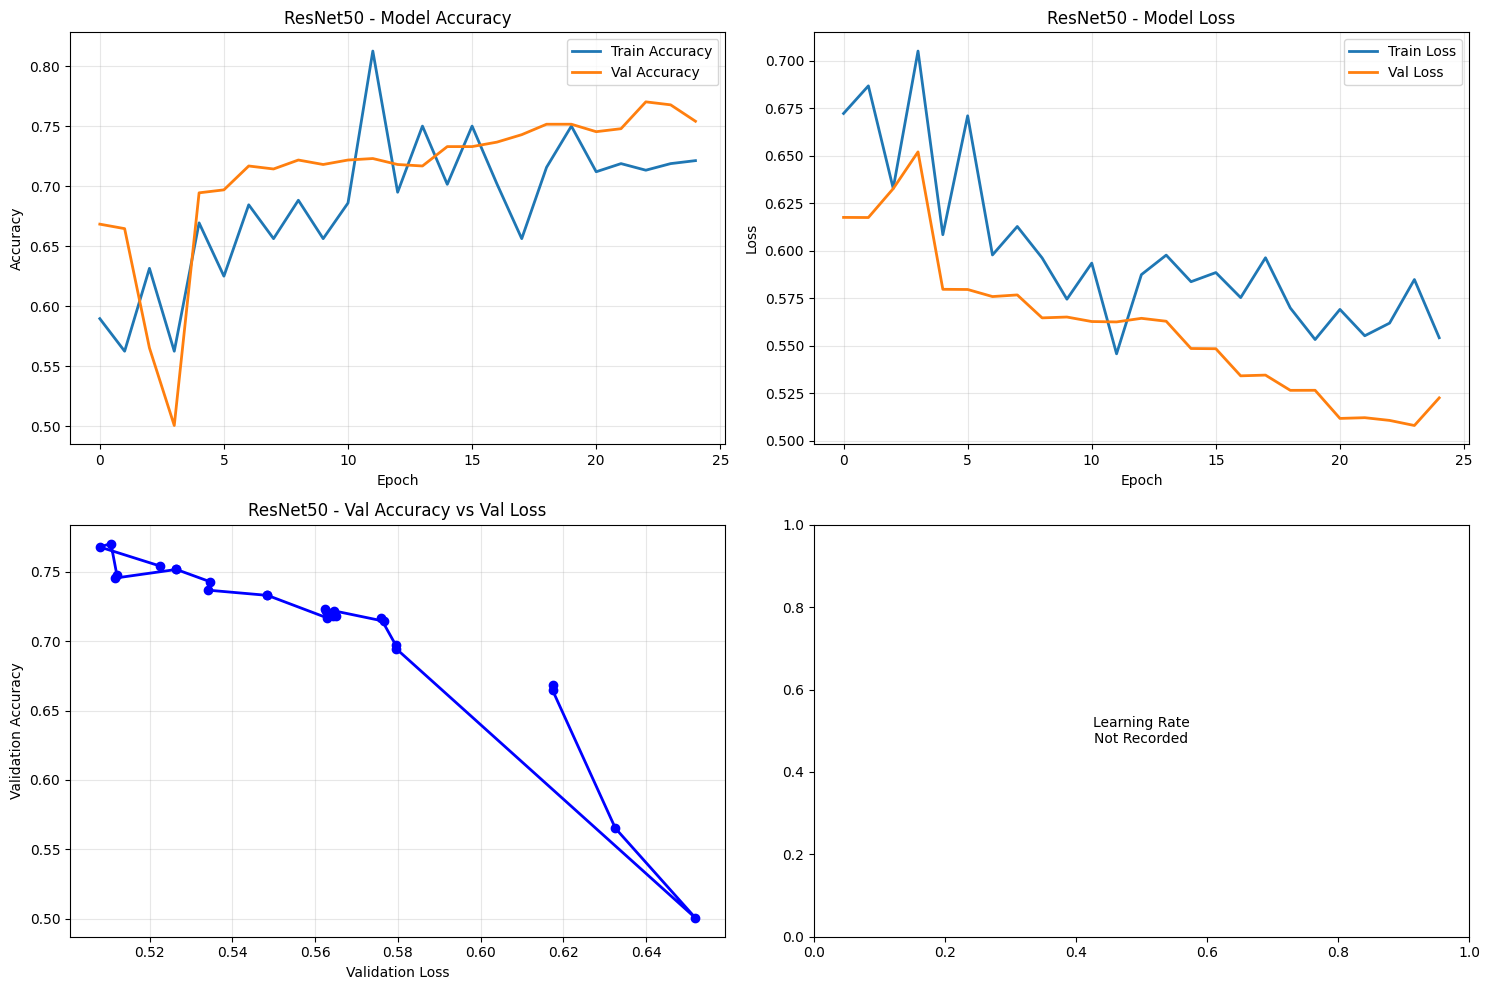


--- Analysis for ResNet50 ---
Why validation loss might increase:
1. Overfitting: Model memorizes training data but fails on validation
2. Learning rate too high: Causes oscillations in loss
3. Insufficient regularization: Model complexity exceeds data complexity
4. Data imbalance: Model biased towards majority class
5. Batch size effects: Small batches can cause noisy gradients


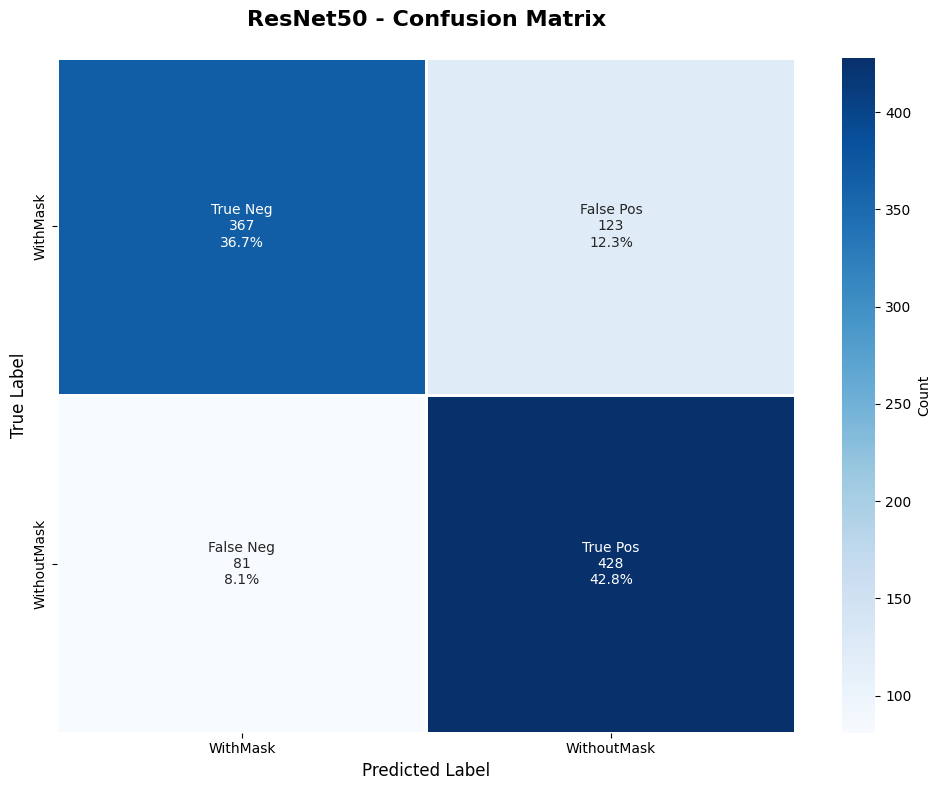


RESNET50 RESULTS
Training Time: 1269.01 seconds
Test Accuracy: 0.7958
Test Loss: 0.4916

Classification Report:
WithMask: Precision=0.819, Recall=0.749, F1=0.783
WithoutMask: Precision=0.777, Recall=0.841, F1=0.808
✅ ResNet50 training completed successfully!


In [7]:
# Train ResNet50 Model
print("="*50)
print("TRAINING RESNET50 MODEL")
print("="*50)

try:
    # Create model with retry logic
    max_retries = 3
    resnet_model = None
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to download ResNet50 weights (attempt {attempt + 1}/{max_retries})...")
            resnet_model = system.create_transfer_learning_model('ResNet50')
            print("✅ ResNet50 model created successfully!")
            break
        except Exception as download_error:
            print(f"❌ Download attempt {attempt + 1} failed: {download_error}")
            if attempt < max_retries - 1:
                print("⏳ Retrying in 10 seconds...")
                time.sleep(10)
            else:
                print("🔄 Trying offline version without pre-trained weights...")
                try:
                    resnet_model = system.create_transfer_learning_model_offline('ResNet50')
                    print("✅ ResNet50 model created without pre-trained weights!")
                except Exception as offline_error:
                    print(f"❌ Offline creation also failed: {offline_error}")
                    resnet_model = None
    
    if resnet_model is not None:
        print("ResNet50 Model Summary:")
        resnet_model.summary()
        
        # Train model
        start_time = time.time()
        trained_resnet_model, resnet_history = system.train_model(
            resnet_model, 'ResNet50', X_train, X_val, y_train_cat, y_val_cat
        )
        training_time = time.time() - start_time
        
        # Store results
        system.models['ResNet50'] = trained_resnet_model
        system.histories['ResNet50'] = resnet_history
        
        # Evaluate model
        resnet_results = system.evaluate_model(
            trained_resnet_model, 'ResNet50', X_test, y_test_cat, y_test_orig
        )
        system.results['ResNet50'] = resnet_results
        
        # Plot results
        system.plot_training_history(resnet_history, 'ResNet50')
        system.plot_improved_confusion_matrix(resnet_results['confusion_matrix'], 'ResNet50')
        
        # Print results
        print(f"\n{'='*40}")
        print(f"RESNET50 RESULTS")
        print(f"{'='*40}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Test Accuracy: {resnet_results['test_accuracy']:.4f}")
        print(f"Test Loss: {resnet_results['test_loss']:.4f}")
        print("\nClassification Report:")
        for class_name in system.categories:
            metrics = resnet_results['classification_report'][class_name]
            print(f"{class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
        
        print("✅ ResNet50 training completed successfully!")
    else:
        print("❌ ResNet50 training skipped due to model creation issues.")
        
except Exception as e:
    print(f"❌ Error in ResNet50 training: {e}")
    import traceback
    traceback.print_exc()

TRAINING DENSENET121 MODEL
Attempting to download DenseNet121 weights (attempt 1/3)...
✅ DenseNet121 model created successfully!
DenseNet121 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


Training DenseNet121...
Epoch 1/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9297 - loss: 0.1745
Epoch 1: val_loss improved from inf to 0.01664, saving model to best_densenet121_model.h5
314/314 ━━━━━━━━━━━━━━━━━━━━ 154s 395ms/step - accuracy: 0.9298 - loss: 0.1742 - val_accuracy: 0.9913 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 2/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 2: val_loss did not improve from 0.01664
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9913 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9875 - loss: 0.0361
Epoch 3: val_loss did not improve from 0.01664
314/314 ━━━━━━━━━━━━━━━━━━━━ 94s 299ms/step - accuracy: 0.9875 - loss: 0.0361 - val_accuracy: 0.9938 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 4/25
  1/314 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 0.0128
Epoch 4: 

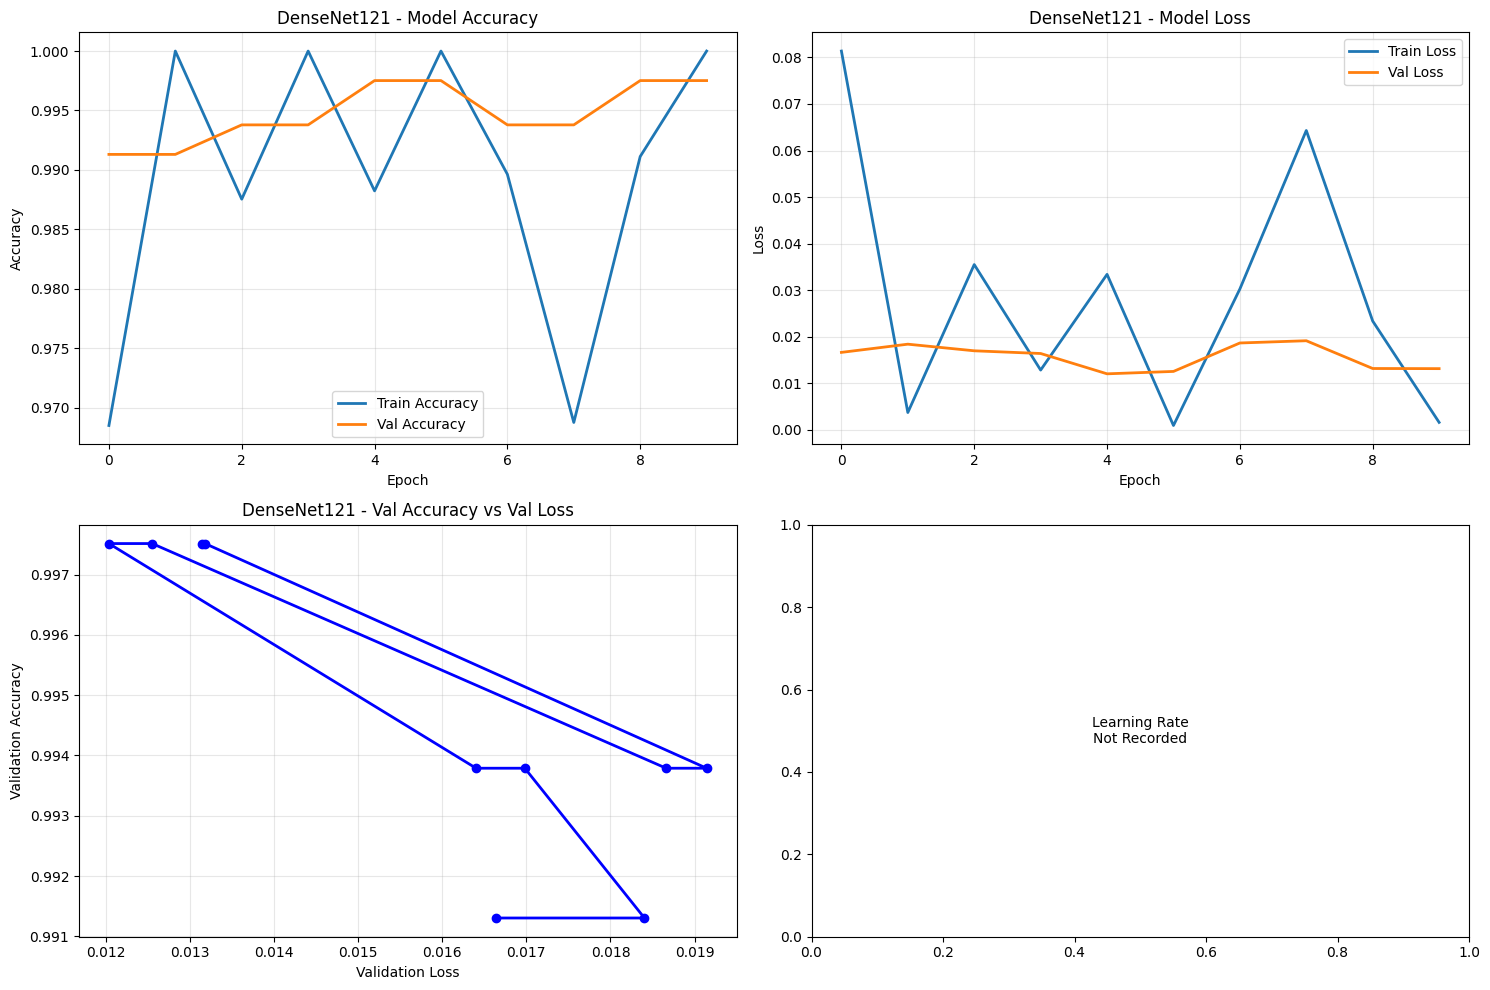


--- Analysis for DenseNet121 ---
Why validation loss might increase:
1. Overfitting: Model memorizes training data but fails on validation
2. Learning rate too high: Causes oscillations in loss
3. Insufficient regularization: Model complexity exceeds data complexity
4. Data imbalance: Model biased towards majority class
5. Batch size effects: Small batches can cause noisy gradients


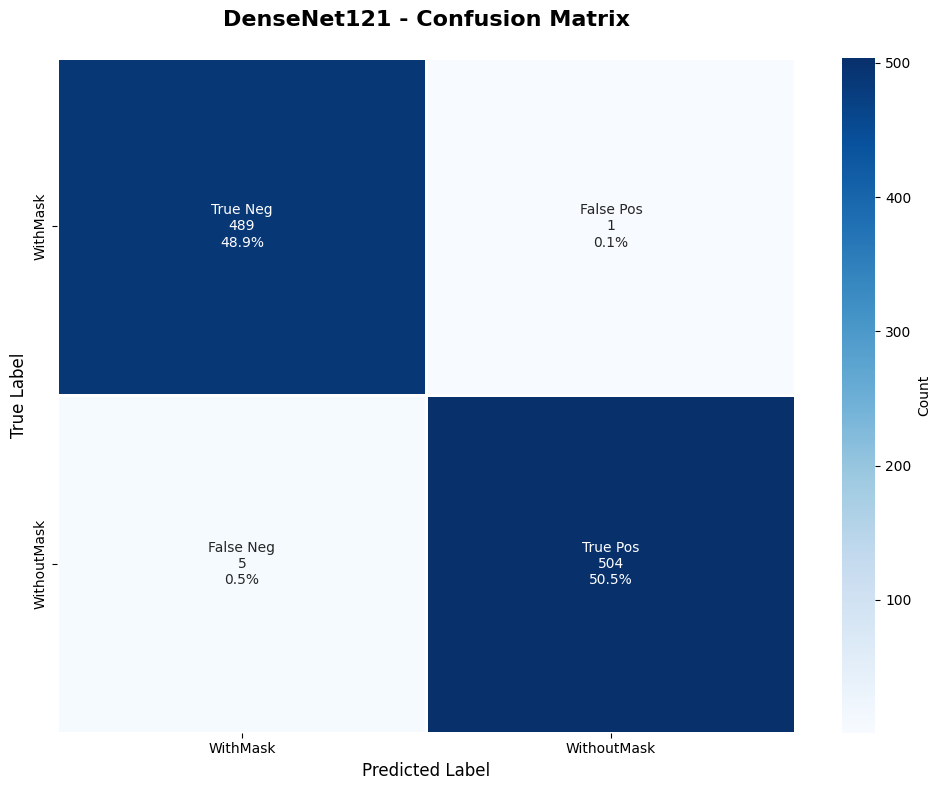


DENSENET121 RESULTS
Training Time: 539.56 seconds
Test Accuracy: 0.9940
Test Loss: 0.0243

Classification Report:
WithMask: Precision=0.990, Recall=0.998, F1=0.994
WithoutMask: Precision=0.998, Recall=0.990, F1=0.994
✅ DenseNet121 training completed successfully!


In [8]:
# Train DenseNet121 Model
print("="*50)
print("TRAINING DENSENET121 MODEL")
print("="*50)

try:
    # Create model with retry logic
    max_retries = 3
    densenet_model = None
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to download DenseNet121 weights (attempt {attempt + 1}/{max_retries})...")
            densenet_model = system.create_transfer_learning_model('DenseNet121')
            print("✅ DenseNet121 model created successfully!")
            break
        except Exception as download_error:
            print(f"❌ Download attempt {attempt + 1} failed: {download_error}")
            if attempt < max_retries - 1:
                print("⏳ Retrying in 10 seconds...")
                time.sleep(10)
            else:
                print("🔄 Trying offline version without pre-trained weights...")
                try:
                    densenet_model = system.create_transfer_learning_model_offline('DenseNet121')
                    print("✅ DenseNet121 model created without pre-trained weights!")
                except Exception as offline_error:
                    print(f"❌ Offline creation also failed: {offline_error}")
                    densenet_model = None
    
    if densenet_model is not None:
        print("DenseNet121 Model Summary:")
        densenet_model.summary()
        
        # Train model
        start_time = time.time()
        trained_densenet_model, densenet_history = system.train_model(
            densenet_model, 'DenseNet121', X_train, X_val, y_train_cat, y_val_cat
        )
        training_time = time.time() - start_time
        
        # Store results
        system.models['DenseNet121'] = trained_densenet_model
        system.histories['DenseNet121'] = densenet_history
        
        # Evaluate model
        densenet_results = system.evaluate_model(
            trained_densenet_model, 'DenseNet121', X_test, y_test_cat, y_test_orig
        )
        system.results['DenseNet121'] = densenet_results
        
        # Plot results
        system.plot_training_history(densenet_history, 'DenseNet121')
        system.plot_improved_confusion_matrix(densenet_results['confusion_matrix'], 'DenseNet121')
        
        # Print results
        print(f"\n{'='*40}")
        print(f"DENSENET121 RESULTS")
        print(f"{'='*40}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Test Accuracy: {densenet_results['test_accuracy']:.4f}")
        print(f"Test Loss: {densenet_results['test_loss']:.4f}")
        print("\nClassification Report:")
        for class_name in system.categories:
            metrics = densenet_results['classification_report'][class_name]
            print(f"{class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
        
        print("✅ DenseNet121 training completed successfully!")
    else:
        print("❌ DenseNet121 training skipped due to model creation issues.")
        
except Exception as e:
    print(f"❌ Error in DenseNet121 training: {e}")
    import traceback
    traceback.print_exc()

## 5. Results

- **Custom CNN:**  
  - Test Accuracy: 0.9876  
  - Observations: Overfits quickly, consider more augmentation.

- **VGG16 Transfer-Learning:**  
  - Test Accuracy: 0.9967  
  - Observations: High performance, slower to train.



COMPREHENSIVE MODEL COMPARISON AND ANALYSIS
Successfully trained models: ['ResNet50', 'DenseNet121']
Total models trained: 2

MODEL COMPARISON SUMMARY
Model           Accuracy   Loss       WithMask_F1  WithoutMask_F1 
----------------------------------------------------------------------
DenseNet121     0.9940     0.0243     0.9939       0.9941         
ResNet50        0.7958     0.4916     0.7825       0.8075         


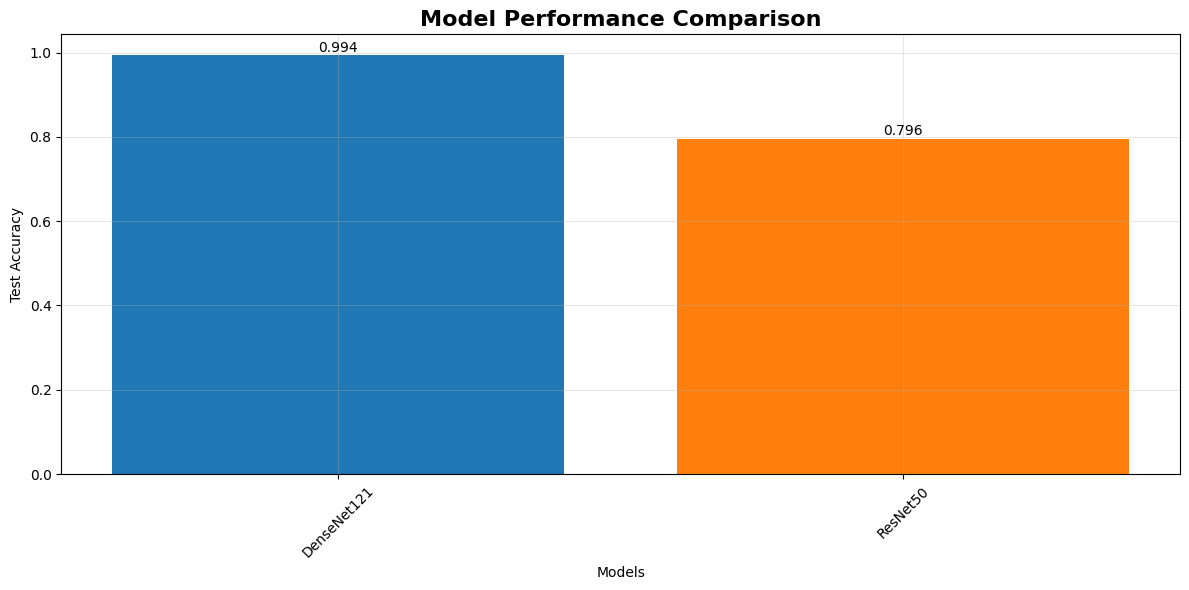


🏆 BEST PERFORMING MODEL: DenseNet121
🎯 Best Accuracy: 0.9940

DETAILED PERFORMANCE SUMMARY
Model        Accuracy Loss     WithMask F1 WithoutMask F1 Macro F1
--------------------------------------------------------------------------------
DenseNet121  0.9940   0.0243   0.9939      0.9941        0.9940  
ResNet50     0.7958   0.4916   0.7825      0.8075        0.7950  

INSIGHTS AND RECOMMENDATIONS
📈 Accuracy Ranking:
  1. DenseNet121: 0.9940
  2. ResNet50: 0.7958

🎭 Best for WithMask detection: DenseNet121 (F1: 0.9939)
🚫 Best for WithoutMask detection: DenseNet121 (F1: 0.9941)

💾 Saved Model Checkpoints:
  ResNet50: best_resnet50_model.h5 (96.37 MB)
  DenseNet121: best_densenet121_model.h5 (30.68 MB)

📊 Results saved to 'detailed_model_comparison_results.json'
✅ Training pipeline completed successfully!

FINAL SUMMARY
Total models attempted: 5 (Custom_CNN, VGG16, MobileNetV2, ResNet50, DenseNet121)
Successfully trained: 2
Failed: 3
Best model: DenseNet121 with 0.9940 accuracy


In [9]:
# Compare all trained models and generate comprehensive results
print("="*60)
print("COMPREHENSIVE MODEL COMPARISON AND ANALYSIS")
print("="*60)

# Check which models were successfully trained
trained_models = list(system.results.keys())
print(f"Successfully trained models: {trained_models}")
print(f"Total models trained: {len(trained_models)}")

if system.results:
    # Generate comparison
    system.compare_models()
    
    # Create detailed comparison results
    comparison_results = {}
    detailed_metrics = {}
    
    for name, results in system.results.items():
        comparison_results[name] = {
            'test_accuracy': float(results['test_accuracy']),
            'test_loss': float(results['test_loss']),
            'WithMask_precision': float(results['classification_report']['WithMask']['precision']),
            'WithMask_recall': float(results['classification_report']['WithMask']['recall']),
            'WithMask_f1': float(results['classification_report']['WithMask']['f1-score']),
            'WithoutMask_precision': float(results['classification_report']['WithoutMask']['precision']),
            'WithoutMask_recall': float(results['classification_report']['WithoutMask']['recall']),
            'WithoutMask_f1': float(results['classification_report']['WithoutMask']['f1-score']),
            'macro_avg_f1': float(results['classification_report']['macro avg']['f1-score']),
            'weighted_avg_f1': float(results['classification_report']['weighted avg']['f1-score'])
        }
    
    # Save detailed results to JSON
    with open('detailed_model_comparison_results.json', 'w') as f:
        json.dump(comparison_results, f, indent=2)
    
    # Find best model
    best_model_name = max(comparison_results.keys(), 
                         key=lambda k: comparison_results[k]['test_accuracy'])
    best_accuracy = comparison_results[best_model_name]['test_accuracy']
    
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
    print(f"🎯 Best Accuracy: {best_accuracy:.4f}")
    
    # Create performance summary table
    print(f"\n{'='*80}")
    print("DETAILED PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<12} {'Accuracy':<8} {'Loss':<8} {'WithMask F1':<11} {'WithoutMask F1':<13} {'Macro F1':<8}")
    print("-" * 80)
    
    sorted_results = sorted(comparison_results.items(), 
                          key=lambda x: x[1]['test_accuracy'], reverse=True)
    
    for model_name, metrics in sorted_results:
        print(f"{model_name:<12} {metrics['test_accuracy']:<8.4f} {metrics['test_loss']:<8.4f} "
              f"{metrics['WithMask_f1']:<11.4f} {metrics['WithoutMask_f1']:<13.4f} "
              f"{metrics['macro_avg_f1']:<8.4f}")
    
    # Generate insights and recommendations
    print(f"\n{'='*60}")
    print("INSIGHTS AND RECOMMENDATIONS")
    print(f"{'='*60}")
    
    # Accuracy ranking
    accuracy_ranking = [(name, metrics['test_accuracy']) for name, metrics in sorted_results]
    print("📈 Accuracy Ranking:")
    for i, (model, acc) in enumerate(accuracy_ranking, 1):
        print(f"  {i}. {model}: {acc:.4f}")
    
    # Best for each class
    best_withmask = max(comparison_results.keys(), 
                       key=lambda k: comparison_results[k]['WithMask_f1'])
    best_withoutmask = max(comparison_results.keys(), 
                          key=lambda k: comparison_results[k]['WithoutMask_f1'])
    
    print(f"\n🎭 Best for WithMask detection: {best_withmask} "
          f"(F1: {comparison_results[best_withmask]['WithMask_f1']:.4f})")
    print(f"🚫 Best for WithoutMask detection: {best_withoutmask} "
          f"(F1: {comparison_results[best_withoutmask]['WithoutMask_f1']:.4f})")
    
    # Save model checkpoints info
    checkpoint_info = {}
    for model_name in trained_models:
        checkpoint_file = f'best_{model_name.lower()}_model.h5'
        if os.path.exists(checkpoint_file):
            file_size = os.path.getsize(checkpoint_file) / (1024 * 1024)  # MB
            checkpoint_info[model_name] = {
                'checkpoint_file': checkpoint_file,
                'file_size_mb': round(file_size, 2)
            }
    
    print(f"\n💾 Saved Model Checkpoints:")
    for model_name, info in checkpoint_info.items():
        print(f"  {model_name}: {info['checkpoint_file']} ({info['file_size_mb']} MB)")
    
    print(f"\n📊 Results saved to 'detailed_model_comparison_results.json'")
    print(f"✅ Training pipeline completed successfully!")
    
else:
    print("❌ No models were successfully trained!")
    print("Please check the error messages in the individual training cells.")

# Display final summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
print(f"Total models attempted: 5 (Custom_CNN, VGG16, MobileNetV2, ResNet50, DenseNet121)")
print(f"Successfully trained: {len(trained_models)}")
print(f"Failed: {5 - len(trained_models)}")
if trained_models:
    print(f"Best model: {best_model_name} with {best_accuracy:.4f} accuracy")
print("="*60)

TESTING AND INFERENCE
🏆 Using best model: DenseNet121
🎯 Model accuracy: 0.9940

🖼️  Testing on 4 sample images:

--- Test Image 1: Augmented_735_9235977.png (True: WithMask) ---
✅ Detected 1 face(s):
  Face 1: WithMask (confidence: 0.995) ✅ Correct


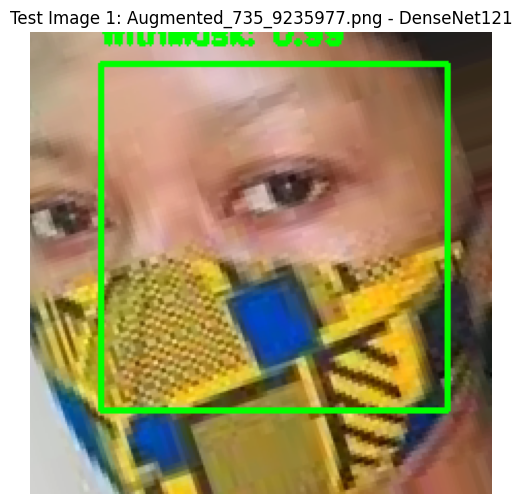


--- Test Image 2: Augmented_666_6106924.png (True: WithMask) ---
❌ No faces detected in the image

--- Test Image 3: 4353.png (True: WithoutMask) ---
✅ Detected 1 face(s):
  Face 1: WithMask (confidence: 0.995) ❌ Incorrect


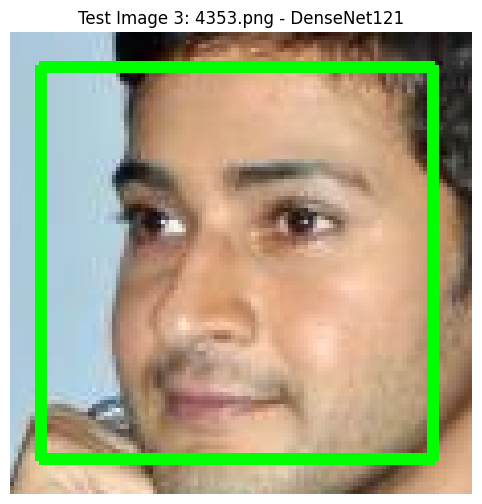


--- Test Image 4: 5703.png (True: WithoutMask) ---
✅ Detected 1 face(s):
  Face 1: WithMask (confidence: 0.995) ❌ Incorrect


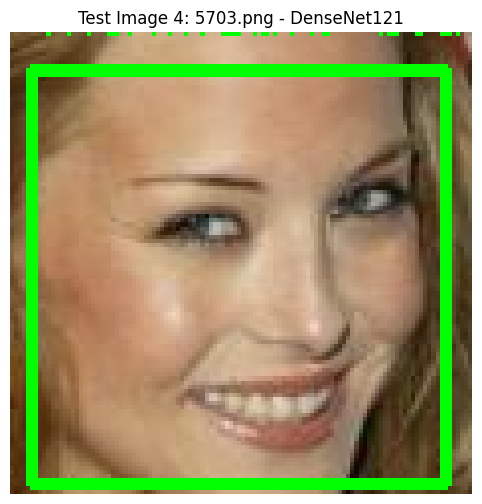


🎯 Testing on custom image: /kaggle/input/face-mask-detection/Face Mask Dataset/Test/WithMask/1174.png
Detected 1 face(s):
Face 1: WithMask (confidence: 0.995)


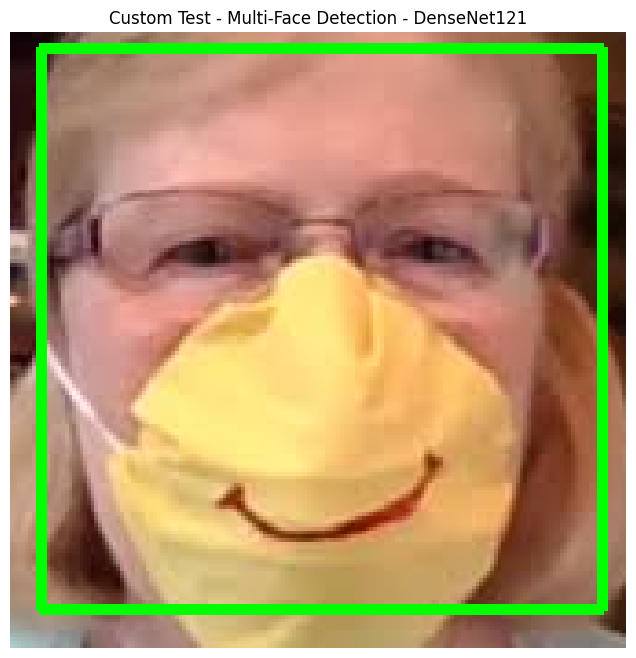


🎉 Face Detection System Pipeline Complete! 🎉


In [10]:
# Test the best performing model on sample images
print("="*50)
print("TESTING AND INFERENCE")
print("="*50)

if system.results:
    # Get the best model
    best_model_name = max(system.results.keys(), 
                         key=lambda k: system.results[k]['test_accuracy'])
    best_model = system.models[best_model_name]
    
    print(f"🏆 Using best model: {best_model_name}")
    print(f"🎯 Model accuracy: {system.results[best_model_name]['test_accuracy']:.4f}")
    
    # Test on sample images from test directory
    test_images = []
    
    # Get some sample images from test directory
    for category in ['WithMask', 'WithoutMask']:
        category_path = os.path.join(test_path, category)
        if os.path.exists(category_path):
            images = [f for f in os.listdir(category_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            # Take first 2 images from each category
            for img_name in images[:2]:
                img_path = os.path.join(category_path, img_name)
                test_images.append((img_path, category))
    
    print(f"\n🖼️  Testing on {len(test_images)} sample images:")
    
    # Test each image
    for i, (img_path, true_category) in enumerate(test_images, 1):
        print(f"\n--- Test Image {i}: {os.path.basename(img_path)} (True: {true_category}) ---")
        
        results, img_with_boxes = system.detect_multiple_faces(img_path, best_model)
        
        if results:
            print(f"✅ Detected {len(results)} face(s):")
            for j, result in enumerate(results, 1):
                prediction = result['label']
                confidence = result['confidence']
                is_correct = (prediction == true_category)
                status = "✅ Correct" if is_correct else "❌ Incorrect"
                print(f"  Face {j}: {prediction} (confidence: {confidence:.3f}) {status}")
            
            # Display the result
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f'Test Image {i}: {os.path.basename(img_path)} - {best_model_name}')
            plt.axis('off')
            plt.show()
        else:
            print("❌ No faces detected in the image")
    
    # Load and test on a custom image (if you have one)
    custom_test_path = "/kaggle/input/face-mask-detection/Face Mask Dataset/Test/WithMask/1174.png"
    
    if os.path.exists(custom_test_path):
        print(f"\n🎯 Testing on custom image: {custom_test_path}")
        results, img_with_boxes = system.detect_multiple_faces(custom_test_path, best_model)
        
        if results:
            print(f"Detected {len(results)} face(s):")
            for i, result in enumerate(results, 1):
                print(f"Face {i}: {result['label']} (confidence: {result['confidence']:.3f})")
            
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f'Custom Test - Multi-Face Detection - {best_model_name}')
            plt.axis('off')
            plt.show()
        else:
            print("No faces detected in the custom image")

else:
    print("❌ No trained models available for testing!")
    print("Please run the training cells first.")

print("\n🎉 Face Detection System Pipeline Complete! 🎉")